In [18]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:

DATA_DIR = "../../data2/processed224"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 6

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    rescale=1./255
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="sparse"  # ou "categorical"
)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="sparse"
)

Found 85000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
2657/2657 [==============================] - 452s 169ms/step - loss: 1.6881 - accuracy: 0.2931 - val_loss: 1.5960 - val_accuracy: 0.3547 - lr: 1.0000e-04
Epoch 2/10
2657/2657 [==============================] - 469s 177ms/step - loss: 1.5828 - accuracy: 0.3527 - val_loss: 1.5475 - val_accuracy: 0.3807 - lr: 1.0000e-04
Epoch 3/10
  51/2657 [..............................] - ETA: 6:44 - loss: 1.5811 - accuracy: 0.3511

KeyboardInterrupt: 

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

94/94 [==============================] - 3s 30ms/step - loss: 1.4445 - accuracy: 0.4317
Test Accuracy: 0.43


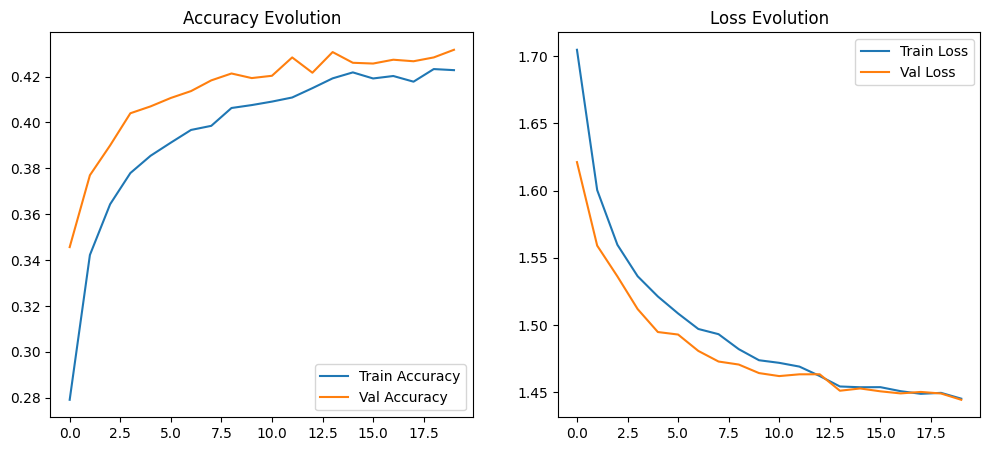

In [ ]:
# 🔹 Évaluation
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# 🔹 Courbes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Evolution')

plt.show()